<a href="https://colab.research.google.com/github/dromero1/voice-gender-recognition-autoencoder/blob/main/src/voice_gender_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Voice Gender Dimensionality Reduction (Autoencoder)

In [1]:
%matplotlib inline

*Mount drive*

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


*Import libraries*

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings as wa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from drive.MyDrive.modules.scratch.mlp import MultilayerPerceptron
from drive.MyDrive.modules.scratch.activation_function import sigmoid

*Paths*

In [4]:
data_path = 'drive/MyDrive/voice_gender_recognition/data/'
figs_path = 'drive/MyDrive/voice_gender_recognition/figs/'

*Global parameters*

In [5]:
dim = 10

*Filter warnings*

In [6]:
wa.filterwarnings('ignore') 

## 1. Preprocessing

*Read dataset*

In [7]:
dataset = pd.read_csv(data_path + 'voice.csv')

*Feature matrix*

In [8]:
features = dataset.iloc[:, :-1].values

*Label vector*

In [9]:
labels = dataset.iloc[:, -1].values

## 2. Learning

*Split in train and rest*

In [10]:
features_train, features_rest, labels_train, labels_rest = train_test_split(features, labels, test_size=0.40)

*Split in validation and test*

In [11]:
features_val, features_test, labels_val, labels_test = train_test_split(features, labels, test_size=0.50)

*Scale features*

In [12]:
sc = MinMaxScaler()
features_train = sc.fit_transform(features_train)
features_val = sc.transform(features_val)
features_test = sc.transform(features_test)

*Select architecture*

In [13]:
architecture = [features.shape[1], dim, features.shape[1]]
architecture

[20, 10, 20]

*Select activation functions*

In [14]:
activations = [sigmoid for _ in range(len(architecture) - 1)]

*Train model*

In [15]:
brain = MultilayerPerceptron(architecture, activations, learning_rate=0.9)
network_avg_errors, gradients_sums = brain.fit(features_train, features_train, epochs=50)

## 3. Visualization

*Render epochs*

In [16]:
epochs = np.linspace(1, network_avg_errors.shape[0], network_avg_errors.shape[0])

*Plot training curve*

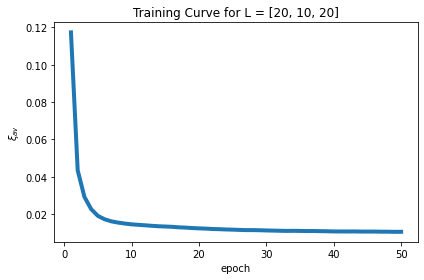

In [17]:
plt.figure()
plt.plot(epochs, network_avg_errors, linewidth=4)
plt.ylabel(r'$\xi_{av}$')
plt.xlabel('epoch')
plt.title('Training Curve for L = {}'.format(architecture))
plt.tight_layout()
plt.savefig(figs_path + 'autoencoder_training_curve.pdf')
plt.show()

*Plot gradients' curves*

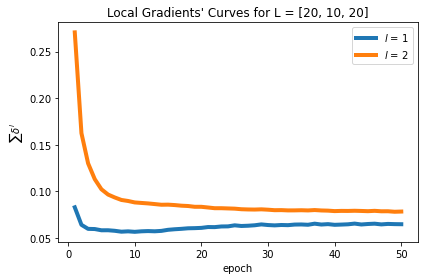

In [18]:
plt.figure()
for layer in range(gradients_sums.shape[1]):
    plt.plot(epochs, gradients_sums[:, layer], linewidth=4, label='$l$ = {}'.format(layer + 1))
plt.ylabel(r'$\sum\delta^l$')
plt.xlabel('epoch')
plt.title("Local Gradients' Curves for L = {}".format(architecture))
plt.tight_layout()
plt.legend()
plt.savefig(figs_path + 'autoencoder_local_gradients.pdf')
plt.show()

*Predict labels*

In [19]:
labels_train_pred = brain.predict(features_train)
labels_val_pred = brain.predict(features_val)
labels_test_pred = brain.predict(features_test)

## 4. Dimensionality reduction

*Initialize reduced feature matrix*

In [20]:
reduced_features = np.zeros(shape=(features.shape[0], dim))

*Extract encoding weights*

In [21]:
encoding_weights = brain.weights[0]

*Remove bias weights*

In [22]:
encoding_weights = encoding_weights[:features.shape[1]]

*Compute local fields*

In [23]:
local_fields = np.matmul(features, encoding_weights)

*Apply activation function*

In [24]:
eval_activation, _ = activations[0]()
for idx, local_field in enumerate(local_fields):
    instance = eval_activation(local_field)
    reduced_features[idx, :] = instance

*Build reduced dataset*

In [25]:
reduced_dataset = pd.DataFrame(reduced_features)
reduced_dataset['label'] = labels

*Persist reduced dataset*

In [26]:
reduced_dataset.to_csv(data_path + 'reduced_voice.csv')